In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

%matplotlib inline
pd.set_option('display.max_columns',500)

In [30]:
df = pd.read_csv('Heart3.csv')

In [31]:
df.head()

,age,sex,cp,trestbps,chol,restecg,thalach,exang,oldpeak,slope,ca,thal,MEDV
0,63,1,3,145,233,0,150,0,2.3,0,0,1,s
1,37,1,2,130,250,1,187,0,3.5,0,0,2,s
2,41,0,1,130,204,0,172,0,1.4,2,0,2,s
3,56,1,1,120,236,1,178,0,0.8,2,0,2,s
4,57,0,0,120,354,1,163,1,0.6,2,0,2,s


In [32]:
df.shape

(303, 13)

In [33]:
df.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'restecg', 'thalach', 'exang',
       'oldpeak', 'slope', 'ca', 'thal', 'MEDV'],
      dtype='object')

In [34]:
df['TARGET']= (df['MEDV'] == 's').astype(int)

In [35]:
varc = ['oldpeak', 'chol', 'thalach', 'trestbps','age']

In [36]:
vard = ['cp', 'restecg', 'exang','slope', 'ca', 'thal', 'sex']

In [37]:
lst_iv = []
for i,v in enumerate(varc):
    if i >= 0:
        max_iv = 0
        bestk = 0
        for k in range(2,6):
            aux = df[[v,'TARGET']].copy()
            aux[v] = pd.cut(aux[v],bins=k,include_lowest=True).astype(str) 
            aux['n'] = 1
            aux = aux.pivot_table(index=v,
                                  columns='TARGET',
                                  values='n',
                                  aggfunc='count')
            aux.reset_index(inplace=True)
            for j in range(2):
                aux[j] = aux[j]/aux[j].sum()
            aux['woe'] = np.log(aux[0]/aux[1])
            aux['iv'] = aux['woe']*(aux[0]-aux[1])
            iv = aux['iv'].sum()
            if (iv>max_iv) & (~np.isinf(iv)):
                max_iv = iv
                bestk = k
        aux = df[[v,'TARGET']].copy()
        aux[v] = pd.cut(aux[v],bins=bestk,include_lowest=True).astype(str) 
        aux['n'] = 1
        aux = aux.pivot_table(index=v,
                              columns='TARGET',
                              values='n',
                              aggfunc='count')
        aux.reset_index(inplace=True)
        for j in range(2):
            aux[j] = aux[j]/aux[j].sum()
        aux['woe'] = np.log(aux[0]/aux[1])
        df[v] = pd.cut(df[v],bins=bestk,include_lowest=True).astype(str)
        df = df.merge(aux[[v,'woe']],on=v,how='inner')
        df.rename(columns={'woe':'W_%s'%v[0:]},inplace=True)
        lst_iv.append((v,max_iv,bestk))

In [38]:
df_iv = pd.DataFrame(lst_iv,columns=['caracteristica','iv','bins'])
df_iv.sort_values('iv',ascending=False,inplace=True)
df_iv

,caracteristica,iv,bins
2,thalach,0.800539,4
0,oldpeak,0.729636,5
4,age,0.336340,4
1,chol,0.099808,3
3,trestbps,0.084330,4


In [39]:
lst_iv = []
for i,v in enumerate(vard):
    aux = df[[v,'TARGET']].copy()
    aux['n'] = 1
    aux = aux.pivot_table(index=v,
                          columns='TARGET',
                          values='n',
                          aggfunc='count')
    aux.reset_index(inplace=True)
    for j in range(2):
        aux[j] = aux[j]/aux[j].sum()
    aux['woe'] = np.log(aux[0]/aux[1])
    aux['iv'] = aux['woe']*(aux[0]-aux[1])
    df = df.merge(aux[[v,'woe']],on=v,how='inner')
    df.rename(columns={'woe':'W_%s'%v[0:]},inplace=True)
    lst_iv.append((v,aux['iv'].sum(),np.nan))

In [40]:
df_iv = df_iv.append(pd.DataFrame(lst_iv,columns=['caracteristica','iv','bins']))
df_iv.sort_values('iv',ascending=False,inplace=True)
df_iv

,caracteristica,iv,bins
5,thal,1.261328,NaN
0,cp,1.210126,NaN
4,ca,1.108452,NaN
2,exang,0.832505,NaN
2,thalach,0.800539,4.0
0,oldpeak,0.729636,5.0
3,slope,0.674946,NaN
6,sex,0.341766,NaN
4,age,0.336340,4.0
1,restecg,0.136141,NaN


In [41]:
best_features=['W_%s'%x[0:] for x in list(df_iv.loc[df_iv.iv>=0.05]['caracteristica'])]

In [42]:
X = df[best_features].copy()
y = df['TARGET'].copy()

In [43]:
df.head()

,age,sex,cp,trestbps,chol,restecg,thalach,exang,oldpeak,slope,ca,thal,MEDV,TARGET,W_oldpeak,W_chol,W_thalach,W_trestbps,W_age,W_cp,W_restecg,W_exang,W_slope,W_ca,W_thal,W_sex
0,"(53.0, 65.0]",1,3,"(120.5, 147.0]","(125.56099999999999, 272.0]",0,"(136.5, 169.25]",0,"(1.24, 2.48]",0,0,1,s,1,0.430006,-0.185646,-0.108990,0.034652,0.549066,-0.647987,0.328632,-0.650001,0.466374,-0.88218,0.871839,0.382291
1,"(41.0, 53.0]",1,0,"(93.893, 120.5]","(125.56099999999999, 272.0]",1,"(136.5, 169.25]",1,"(2.48, 3.72]",0,0,1,n,0,2.412284,-0.185646,-0.108990,-0.304735,-0.606829,1.159521,-0.360305,1.373931,0.466374,-0.88218,0.871839,0.382291
2,"(41.0, 53.0]",1,3,"(93.893, 120.5]","(125.56099999999999, 272.0]",0,"(169.25, 202.0]",0,"(-0.0072, 1.24]",1,0,1,s,1,-0.522003,-0.185646,-1.489015,-0.304735,-0.606829,-0.647987,0.328632,-0.650001,0.797731,-0.88218,0.871839,0.382291
3,"(28.951, 41.0]",1,1,"(120.5, 147.0]","(125.56099999999999, 272.0]",1,"(103.75, 136.5]",0,"(-0.0072, 1.24]",1,0,1,s,1,-0.522003,-0.185646,1.146276,0.034652,-0.966441,-1.337656,-0.360305,-0.650001,0.797731,-0.88218,0.871839,0.382291
4,"(53.0, 65.0]",1,0,"(120.5, 147.0]","(125.56099999999999, 272.0]",1,"(136.5, 169.25]",0,"(-0.0072, 1.24]",1,0,1,s,1,-0.522003,-0.185646,-0.108990,0.034652,0.549066,1.159521,-0.360305,-0.650001,0.797731,-0.88218,0.871839,0.382291


In [55]:
X.describe()

,W_thal,W_cp,W_ca,W_exang,W_thalach,W_oldpeak,W_slope,W_sex,W_age,W_restecg,W_chol,W_trestbps
count,303.000000,303.000000,303.000000,303.000000,303.000000,301.000000,303.000000,303.000000,303.000000,303.000000,302.000000,303.000000
mean,-0.037042,-0.057207,0.002894,0.011284,-0.028063,0.040584,-0.039049,-0.030291,-0.020592,-0.004450,0.004547,0.000036
std,1.185869,1.163008,1.117417,0.950832,0.977338,0.954174,0.850294,0.606845,0.594352,0.373494,0.317355,0.296951
min,-1.105324,-1.337656,-1.207603,-0.650001,-1.489015,-0.522003,-0.938789,-0.919920,-0.966441,-0.360305,-0.185646,-0.304735
25%,-1.105324,-1.165043,-0.882180,-0.650001,-0.108990,-0.522003,-0.938789,-0.919920,-0.606829,-0.360305,-0.185646,-0.304735
50%,-1.105324,-0.647987,-0.882180,-0.650001,-0.108990,-0.522003,0.466374,0.382291,0.118067,-0.360305,-0.185646,0.034652
75%,1.335124,1.159521,0.918359,1.373931,1.146276,0.430006,0.797731,0.382291,0.549066,0.328632,0.532332,0.034652
max,1.335124,1.159521,1.913293,1.373931,2.375916,2.412284,0.797731,0.382291,0.549066,1.277304,0.532332,1.277304


In [56]:
X.drop(['W_oldpeak','W_chol'], inplace=True, axis=1)

In [57]:
Xt, Xv, yt, yv = train_test_split(X,y,train_size=0.8)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [58]:
modelo = LogisticRegression()

In [59]:
modelo.fit(Xt,yt)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

#### Scoring 

In [60]:
PDO = 20
score_base = 280
odds_base = 3
factor = PDO/np.log(2)
offset = score_base-factor*np.log(odds_base)

In [61]:
betas = list(modelo.coef_[0])
alpha = modelo.intercept_[0]

In [62]:
n = len(betas)

In [69]:
best_features = ['W_thal','W_cp','W_ca','W_exang','W_thalach','W_slope','W_sex','W_age','W_restecg','W_trestbps']

In [70]:
for i,v in enumerate(best_features):
    df['P_%s'%v[0:]] = ((-df[v]*betas[i]+alpha/n)*factor+offset/n).astype(int)

In [71]:
df['score'] = df[[v for v in df.columns if v[:2]=='P_']].sum(axis=1)

In [83]:
for v in list(df_iv.loc[df_iv.iv>=0.05]['caracteristica']):
    if(v!='oldpeak' and v!= 'chol'):
        aux = df[[v,'P_W_%s'%v[0:]]].copy()
        aux.drop_duplicates(inplace=True)
        print(aux)

     thal  P_W_thal
0       1        40
17      3        47
119     2         7
206     0        28
   cp  P_W_cp
0   3      12
1   0      48
3   1       0
8   2       2
     ca  P_W_ca
0     0       1
8     1      50
12    2      71
15    3      78
117   4      -7
   exang  P_W_exang
0      0         17
1      1         43
             thalach  P_W_thalach
0    (136.5, 169.25]           23
2    (169.25, 202.0]            2
3    (103.75, 136.5]           43
13  (70.868, 103.75]           62
   slope  P_W_slope
0      0         34
2      1         40
7      2          8
     sex  P_W_sex
0      1       34
207    0        3
              age  P_W_age
0    (53.0, 65.0]       24
1    (41.0, 53.0]       26
3  (28.951, 41.0]       27
7    (65.0, 77.0]       25
    restecg  P_W_restecg
0         0           31
1         1           19
15        2           46
           trestbps  P_W_trestbps
0    (120.5, 147.0]            26
1   (93.893, 120.5]            18
7    (147.0, 173.5]            33

In [89]:
df[['age','sex','TARGET','score']].to_clipboard()

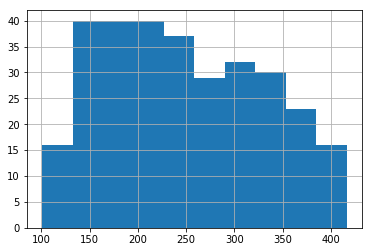

In [72]:
df.score.hist()

In [73]:
df.score.describe()

count    303.000000
mean     248.158416
std       81.287251
min      101.000000
25%      178.500000
50%      241.000000
75%      318.000000
max      416.000000
Name: score, dtype: float64

In [84]:
df['r_score'] = pd.cut(df['score'],bins=range(0,330,30),include_lowest=True).astype(str)

In [85]:
df.pivot_table(index='r_score',
               columns='TARGET',
               aggfunc='count',
               values=varc[0],
               fill_value=0)

TARGET,0,1
r_score,,
"(120.0, 150.0]",0,27
"(150.0, 180.0]",2,42
"(180.0, 210.0]",8,33
"(210.0, 240.0]",3,30
"(240.0, 270.0]",18,14
"(270.0, 300.0]",19,8
"(90.0, 120.0]",0,6
nan,88,5
